In [ ]:
%pip install pycaret
%pip install --upgrade scipy


In [ ]:
%pip install -U yellowbrick


In [ ]:
!pip uninstall yellowbrick
!pip install yellowbrick

# Pycaret on Crops dataset

In this notebook we use pycaret to find the best model for predicting the production for the countries in the dataset. We tried different iterations for getting the best features to predict and also the best model.



# 1 Importing crops dataset and needed packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

In [2]:
sheet_stats = ['CropStats']
df = pd.concat(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/CloudAI/crops.xlsx', sheet_name=sheet_stats))
df

Unnamed: 0  Harvest_year   admin0    admin1   crop  \
CropStats 0               0          1902  Austria       NaN  wheat   
          1               1          1903  Austria       NaN  wheat   
          2               2          1904  Austria       NaN  wheat   
          3               3          1905  Austria       NaN  wheat   
          4               4          1906  Austria       NaN  wheat   
...                     ...           ...      ...       ...    ...   
          36702       36702          2013    China  zhejiang  wheat   
          36703       36703          2014    China  zhejiang  wheat   
          36704       36704          2015    China  zhejiang  wheat   
          36705       36705          2016    China  zhejiang  wheat   
          36706       36706          2017    China  zhejiang  wheat   

                 hectares (ha)  production (tonnes)  year  yield(tonnes/ha)  \
CropStats 0                NaN                  NaN  1902          1.310000   
          1                NaN                  NaN  1903          1.470000   
          2                NaN                  NaN  1904          1.270000   
          3                NaN                  NaN  1905          1.330000   
          4                NaN                  NaN  1906          1.280000   
...                        ...                  ...   ...               ...   
          36702        75520.0             278300.0  2013          3.685117   
          36703        82120.0             309500.0  2014          3.768875   
          36704        89800.0             351300.0  2015          3.912027   
          36705        76590.0             253900.0  2016          3.315054   
          36706       103670.0             419200.0  2017          4.043600   

                 admin2 notes  
CropStats 0         NaN   NaN  
          1         NaN   NaN  
          2         NaN   NaN  
          3         NaN   NaN  
          4         NaN   NaN  
...                 ...   ...  
          36702     NaN   NaN  
          36703     NaN   NaN  
          36704     NaN   NaN  
          36705     NaN   NaN  
          36706     NaN   NaN  

[36707 rows x 11 columns]

# 2 Preprocessing of the data for training our model

In [3]:
# Removing the notes column because it is of no use for our model.
notes_values = df['notes'].dropna().tolist()
# Drop the columns notes and admin2 (not useful)
df = df.drop(columns=['notes', 'admin2'])
# Rename 'admin0' to 'Country' and 'admin1' to 'City'
df = df.rename(columns={'admin0': 'Country', 'admin1': 'City'})
df["City"].fillna("Not defined", inplace=True)
# Fill the null values of hectares, production and yield with 0 to not miss any upon calculation
df.fillna(0, inplace=True)
df = df[~((df['production (tonnes)'] == 0) & ((df['yield(tonnes/ha)'] == 0) | (df['hectares (ha)'] == 0)))]
# Find the indexes of rows where 'production' is zero
zero_indexes = df[df['production (tonnes)'] == 0].index
# Loop through the zero valued indexes and calculate the missing 'production' values
for index in zero_indexes:
    df.at[index, 'production (tonnes)'] = df.at[index, 'yield(tonnes/ha)'] * df.at[index, 'hectares (ha)']
# Some might argue that we should keep the row if the production has a value but yield doesn't, but in our case we need rows without zeros for a good prediction
df = df[~((df['yield(tonnes/ha)'] == 0) & ((df['production (tonnes)'] == 0) | (df['hectares (ha)'] == 0)))]
# Some might argue that we should keep the row if the production has a value but hectares doesn't, but in our case we need rows without zeros for a good prediction
df = df[~((df['hectares (ha)'] == 0) & ((df['production (tonnes)'] == 0) | (df['yield(tonnes/ha)'] == 0)))]
# Find the indexes of rows where 'hectares' is zero
zero_indexes = df[df['hectares (ha)'] == 0].index
# Loop through the zero valued indexes and calculate the missing 'hectares' values
for index in zero_indexes:
    df.at[index, 'hectares (ha)'] = df.at[index, 'production (tonnes)'] / df.at[index, 'yield(tonnes/ha)']
# Count the number of rows with 0 in "hectares (ha)" to verify
count_zero_hectares = len(df[df['hectares (ha)'] == 0])
# Select specific columns and reorder them
df = df[['year', 'Harvest_year', 'crop', 'hectares (ha)', 'yield(tonnes/ha)', 'production (tonnes)']]
df = pd.get_dummies(df, columns=['crop'])
cols_to_drop = ['Harvest_year']
df.drop(columns=cols_to_drop, axis=1, inplace=True)
df

year  hectares (ha)  yield(tonnes/ha)  production (tonnes)  \
CropStats 59     1961       275822.0          2.580000           711620.760   
          60     1962       270351.0          2.612000           706156.812   
          61     1963       274722.0          2.510000           689552.220   
          62     1964       282967.0          2.652000           750428.484   
          63     1965       275654.0          2.397000           660742.638   
...               ...            ...               ...                  ...   
          36702  2013        75520.0          3.685117           278300.000   
          36703  2014        82120.0          3.768875           309500.000   
          36704  2015        89800.0          3.912027           351300.000   
          36705  2016        76590.0          3.315054           253900.000   
          36706  2017       103670.0          4.043600           419200.000   

                 crop_cereals  crop_maize  crop_spring wheat  crop_wheat  \
CropStats 59                0           0                  0           1   
          60                0           0                  0           1   
          61                0           0                  0           1   
          62                0           0                  0           1   
          63                0           0                  0           1   
...                       ...         ...                ...         ...   
          36702             0           0                  0           1   
          36703             0           0                  0           1   
          36704             0           0                  0           1   
          36705             0           0                  0           1   
          36706             0           0                  0           1   

                 crop_winter wheat  
CropStats 59                     0  
          60                     0  
          61                     0  
          62                     0  
          63                     0  
...                            ...  
          36702                  0  
          36703                  0  
          36704                  0  
          36705                  0  
          36706                  0  

[34066 rows x 9 columns]

# 3 Set up

In [4]:
# initialize setup
classification_setup = setup(df, target='production (tonnes)', train_size=0.8, session_id=8)

,Description,Value
0,Session id,8
1,Target,production (tonnes)
2,Target type,Regression
3,Original data shape,"(34066, 9)"
4,Transformed data shape,"(34066, 9)"
5,Transformed train set shape,"(27252, 9)"
6,Transformed test set shape,"(6814, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


# 4 Comparing the models

In [5]:
# compare the performance of all estimators
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,18206.3073,35232430331.0440,155074.7222,0.9986,0.0342,0.0093,5.2350
rf,Random Forest Regressor,29905.8844,62068097735.4593,234362.6934,0.9976,0.0391,0.0136,8.6640
dt,Decision Tree Regressor,64366.2930,153501555793.8739,385381.7951,0.9938,0.0585,0.0308,0.2390
gbr,Gradient Boosting Regressor,146139.6985,151013546093.5138,384667.9262,0.9938,1.2116,13.2273,2.3720
xgboost,Extreme Gradient Boosting,77796.7715,391438956953.6000,595193.2594,0.9846,0.4641,0.7256,0.3860
lightgbm,Light Gradient Boosting Machine,87061.5321,452091647248.8073,654986.4682,0.9821,0.6243,2.1881,1.7560
ada,AdaBoost Regressor,1614580.4625,4098312789066.4521,2015286.0597,0.8302,2.8701,468.9169,0.9480
llar,Lasso Least Angle Regression,1168673.4759,8294144974504.0371,2875683.2633,0.6557,2.4067,244.1341,0.0360
ridge,Ridge Regression,1168683.9599,8294130473240.5732,2875679.9353,0.6557,2.4064,244.1458,0.0340
lasso,Lasso Regression,1168673.3596,8294144975764.6309,2875683.2626,0.6557,2.4068,244.1347,0.2730


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

# 5 Creating a model from our best estimator

In [6]:
# create model
model = create_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14694.9338,9798643352.0596,98988.0970,0.9996,0.0496,0.0111
1,17898.7978,19096545783.2281,138190.2521,0.9992,0.0336,0.0101
2,13785.8007,6035728825.8778,77689.9532,0.9997,0.0274,0.0085
3,26382.3532,208903436908.9523,457059.5551,0.9917,0.0425,0.0100
4,20887.6582,37126734288.4177,192682.9891,0.9989,0.0165,0.0072
5,15446.5024,10915701277.6967,104478.2335,0.9994,0.0364,0.0104
6,20227.8427,17809603290.1464,133452.6256,0.9994,0.0384,0.0099
7,18419.1901,17145007802.2772,130938.9469,0.9992,0.0410,0.0081
8,18991.7482,19426330401.5281,139378.3714,0.9992,0.0348,0.0095


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

# 6 Predicting on the model

In [7]:
# predict on test set
predictions = predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,16122.5151,11097753651.1076,105345.8763,0.9996,0.0340,0.0090


# 7 Plotting the results of the best model

## Plotting the error

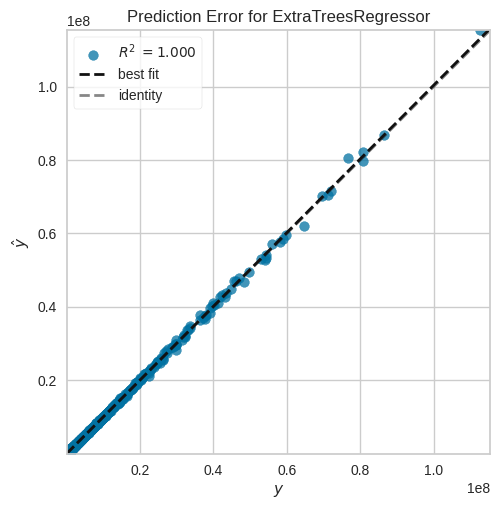

In [22]:
# plot the regression results on a scatter plot
plot_model(model, plot = 'error')

## Manifold plot
This plot shows the dimensionality of the data.

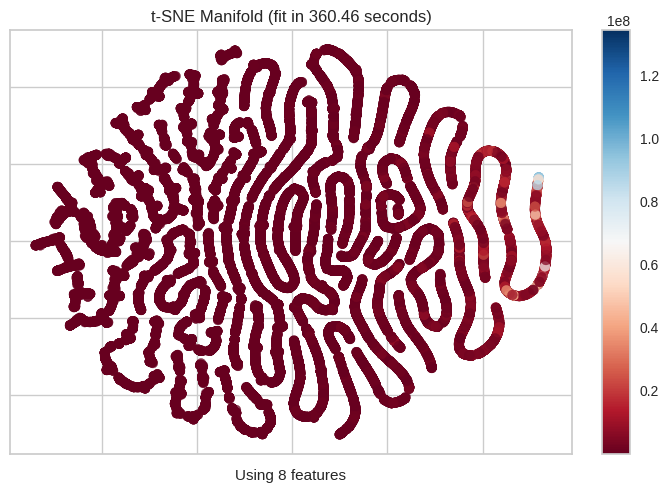

In [23]:
# plot the regression results on a scatter plot
plot_model(model, plot = 'manifold')

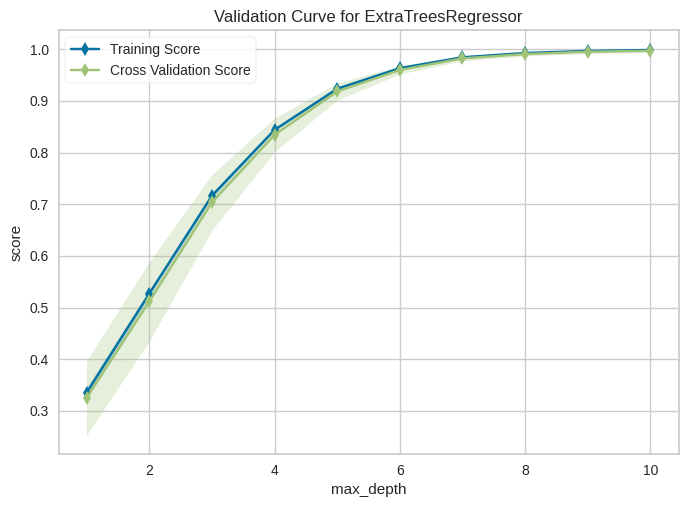

In [24]:
plot_model(model, plot = 'vc')